## Using a PACDataFrame for PAC in Spark

First, we set up our Spark session and import the data.

In [1]:
from pyspark.sql import SparkSession, DataFrame
import numpy as np
import scipy.stats as stats
from tqdm import tqdm

from pacdb import PACDataFrame, SamplerOptions, minimal_permutation_distance, noise_to_add

spark: SparkSession = (SparkSession.builder.appName("pacdb")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", ".spark")
         .enableHiveSupport()
         .getOrCreate())

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

24/03/14 17:36:52 WARN Utils: Your hostname, laelaps-4.local resolves to a loopback address: 127.0.0.1; using 10.139.131.125 instead (on interface en0)
24/03/14 17:36:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/14 17:36:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Create a DataFrame from the Lung Cancer dataset.

In [2]:
lung_df: DataFrame = spark.read.parquet("./data/health_synthetic/lung.parquet")

Peek at the true count of how many people in the dataset are smokers.

In [3]:
smokers: DataFrame = lung_df.filter(lung_df["Smoking"] >= 3) # Smoking is on 1-7 scale
smokers.count()

597

#### 0. Create PACDataFrame
Do all joins, etc. to get the data you want into a single Spark DataFrame. Turn it into a PACDataFrame.

In [4]:
pac_lung_df: PACDataFrame = PACDataFrame.fromDataFrame(lung_df)
               
# Define your query as a function that takes a DataFrame
def A(x: DataFrame) -> int:
    """Query to make private, $A(x)$ in the PAC-ML paper."""
    y = (x.filter(lung_df["Smoking"] >= 3)
             .count())
    return y

# Attach the query function to the PACDataFrame
pac_lung_df = pac_lung_df.withQuery(A)
pac_lung_df

#### 1. Sampling
Set the sampler options on the PACDataFrame, then call the sample method to sample the data.

In [5]:
# Set sampler options on the PACDataFrame
pac_lung_df = (pac_lung_df.withSamplerOptions(
                    SamplerOptions(
                        withReplacement=False, 
                        fraction=0.5
                    ))
                    .setNumberOfTrials(200)
                    .setMutualInformationBound(1./8))

pac_lung_df._subsample()
pac_lung_df.X[0]

Subsample: 100%|██████████| 400/400 [00:02<00:00, 183.43it/s]


[DataFrame[name: string, index: bigint, Patient Id: string, Age: bigint, Gender: bigint, Air Pollution: bigint, Alcohol use: bigint, Dust Allergy: bigint, Occupational Hazards: bigint, Genetic Risk: bigint, Chronic Lung Disease: bigint, Balanced Diet: bigint, Obesity: bigint, Smoking: bigint, Passive Smoker: bigint, Chest Pain: bigint, Coughing of Blood: bigint, Fatigue: bigint, Weight Loss: bigint, Shortness of Breath: bigint, Wheezing: bigint, Swallowing Difficulty: bigint, Clubbing of Finger Nails: bigint, Frequent Cold: bigint, Dry Cough: bigint, Snoring: bigint, Cancer: string],
 DataFrame[name: string, index: bigint, Patient Id: string, Age: bigint, Gender: bigint, Air Pollution: bigint, Alcohol use: bigint, Dust Allergy: bigint, Occupational Hazards: bigint, Genetic Risk: bigint, Chronic Lung Disease: bigint, Balanced Diet: bigint, Obesity: bigint, Smoking: bigint, Passive Smoker: bigint, Chest Pain: bigint, Coughing of Blood: bigint, Fatigue: bigint, Weight Loss: bigint, Shortn

#### 2. Measure Stability

Run the inputs through the mechanism function to get the outputs, which constitute $Y$.

$Y_i = \mathcal{A}(X_i)$ for all $X_i \in X$

In [6]:
pac_lung_df._measure_stability()
pac_lung_df.Y[0]

Measure Stability: 100%|██████████| 400/400 [01:53<00:00,  3.52it/s]


[285, 290, 287]

These are the samples that we have:

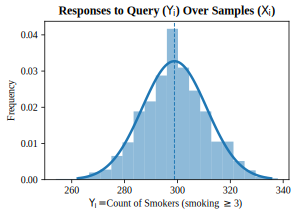

In [7]:
# Plot histogram of samples
Y = np.array(pac_lung_df.Y).flatten()
fig, ax = plt.subplots(figsize=(6.4*(2/3), 4.8*(2/3)))
plt.hist(Y, bins=20, density=True, alpha=0.5, color='tab:blue')

x = np.linspace(np.mean(Y) - 3*np.std(Y), np.mean(Y) + 3*np.std(Y), 100)
plt.plot(x, stats.norm.pdf(x, np.mean(Y), np.std(Y)), color='tab:blue', linewidth=2.5)
plt.axvline(np.mean(Y), color='tab:blue', linestyle='dashed', linewidth=1)

plt.title('Responses to Query ($Y_i$) Over Samples ($X_i$)')
plt.xlabel('$Y_i = $Count of Smokers (smoking $\geq$ 3) ')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("figs/samples.png")

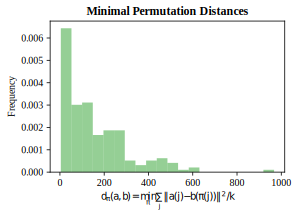

In [8]:
# From samples, compute minimal permutation distances and plot
fig, ax = plt.subplots(figsize=(6.4*(2/3), 4.8*(2/3)))
dists = [minimal_permutation_distance(Y1, Y2) for Y1, Y2 in pac_lung_df.Y_pairs]
plt.hist(dists, bins=20, density=True, alpha=0.5, color='tab:green')

plt.title('Minimal Permutation Distances')
plt.xlabel(r'$d_{\pi}(a, b) = \min_{\pi} \sum_{j} \left\|a(j) - b(\pi(j))\right\|^2 / k$')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("figs/minimal-permutation-distance.png")

### 3. Estimate Noise

Noise is estimated using Algorithm 2 from the PAC paper, with details taken from `rand_mechanism_noise` in the PAC-ML paper.

$\text{noise} = ((\psi + c) / (2*v))$ where $\psi$ is the average distance between paired samples and $v = \tt{max\_mi}/2$

In [9]:
# 3. Estimate Noise
pac_lung_df._estimate_noise()
pac_lung_df.noise_distribution

Measure Distances: 100%|██████████| 200/200 [00:00<00:00, 13314.62it/s]


GaussianDistribution(mean=0, variance=1246.0613333333347)

### 4. Noised Release
Now that the PACDataFrame has analyzed the query and estimated the noise needed, we can release the noised data.

In [10]:
# 4. Noised Release
pac_lung_df._noised_release()

1727.8291334075714

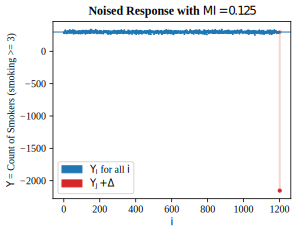

In [12]:
# Plot a single noised response vs original distribution. Generate a new value to release for this plot.
Xj = pac_lung_df.sampler.sample()
Yj = pac_lung_df._applyQuery(Xj)
delta = pac_lung_df.noise_distribution.sample()
noised_Yj = Yj + delta

# plot samples
fig, ax = plt.subplots(figsize=(6.4*(2/3), 4.8*(2/3)))
plt.scatter(range(len(Y)), Y, alpha=1, color='tab:blue', s=1)
plt.axhline(y=np.mean(Y), color='tab:blue', linestyle='-', lw=1)

# plot noised response
plt.scatter([len(Y)+1], [Yj], alpha=0.4, color='tab:red', s=10)
plt.scatter([len(Y)+1], [noised_Yj], alpha=1, color='tab:red', s=10)
# plot arrow from sample to noised response
plt.arrow(len(Y)+1, Yj, 0, noised_Yj-Yj, color='tab:red', alpha=0.2, length_includes_head=True, head_width=3, head_length=3, lw=2)

plt.title(f'Noised Response with $MI = {pac_lung_df.options.max_mi}$')
plt.xlabel('$i$')
plt.ylabel('$Y$ = Count of Smokers (smoking >= 3)')
plt.legend(handles=[mpatches.Patch(color='tab:blue', label='$Y_i$ for all $i$'), mpatches.Patch(color='tab:red', label='$Y_j + \\Delta$')])
#plt.ylim(bottom=0)
plt.savefig("figs/original-vs-noised.png")

100%|██████████| 100/100 [00:06<00:00, 14.48it/s]


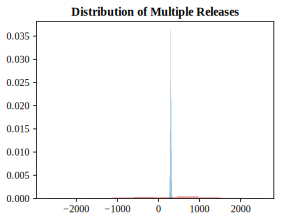

In [13]:
# Plot the distribution of noised release against the original

# To determine the distribution of noised releases, sample many
noised_Yj_samples = [pac_lung_df._noised_release() for _ in tqdm(range(100))]

fig, ax = plt.subplots(figsize=(6.4*(2/3), 4.8*(2/3)))
plt.hist(np.array(pac_lung_df.Y).flatten(), bins=10, density=True, alpha=0.5, color='tab:blue', label='$Y_i$ for all $i$')
plt.hist(noised_Yj_samples, bins=10, density=True, alpha=0.5, color='tab:red', label='$Y_j + \\Delta$')
plt.title("Distribution of Multiple Releases")
plt.show()